<a href="https://colab.research.google.com/github/IraVol/syntheticDataTests/blob/main/IV_synthetic_records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating synthetic data

This notebook walks through training a probabilistic, generative RNN model<br>
on a test customer dataset, and then generating a synthetic<br>
dataset with greater privacy guarantees.

For both training and generating data, we can use the ``config.py`` module and<br>
create a ``LocalConfig`` instance that contains all the attributes that we need<br>
for both activities.

# New section

In [ ]:
!pip install tensorflow==2.8.0
!pip install gretel-synthetics --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

In [ ]:
from pathlib import Path

from gretel_synthetics.config import LocalConfig

# Create a config that we can use for both training and generating data
# The default values for ``max_lines`` and ``epochs`` are optimized for training on a GPU.

config = LocalConfig(
    max_line_len=2048,   # the max line length for input training data
    vocab_size=20000,    # tokenizer model vocabulary size
    field_delimiter=",", # specify if the training text is structured, else ``None``
    overwrite=True,      # overwrite previously trained model checkpoints
    checkpoint_dir=(Path.cwd() / 'checkpoints').as_posix(),
    epochs=5,
    input_data_path="/content/sample_data/testUserData.csv" # filepath or S3
)



In [ ]:
# Train a model
# The training function only requires our config as a single arg

from gretel_synthetics.train import train_rnn

train_rnn(config)

100%|██████████| 10001/10001 [00:00<00:00, 30331.99it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           5120000   
                                                                 
 dropout (Dropout)           (64, None, 256)           0         
                                                                 
 lstm (LSTM)                 (64, None, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (64, None, 256)           0         
                                                                 
 lstm_1 (LSTM)               (64, None, 256)           525312    
                                                                 
 dropout_2 (Dropout)         (64, None, 256)           0         
                                                                 
 dense (Dense)               (64, None, 20000)         5

# New section

Install Flask and set ngrok auth token

In [ ]:
!pip install flask
!pip install pyngrok
!ngrok config add-authtoken 1jxT2ROexXnWTcHZ5kSTevqwsYo_4e9bPARqqb8Wt8nddaWJU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import json
from jsonschema import validate, ValidationError
from gretel_synthetics.generate import generate_text
import copy


from pathlib import Path

from gretel_synthetics.config import LocalConfig

config = LocalConfig(
    max_line_len=2048,   # the max line length for input training data
    vocab_size=20000,    # tokenizer model vocabulary size
    field_delimiter=",", # specify if the training text is structured, else ``None``
    overwrite=True,      # overwrite previously trained model checkpoints
    checkpoint_dir=(Path.cwd() / 'checkpoints').as_posix(),
    epochs=5,
    input_data_path="/content/sample_data/testUserData.csv" # filepath or S3
)


def gen_mapped_result(obj):
    mapped_result = copy.deepcopy(obj)


    if 'id' in mapped_result and isinstance(mapped_result['id'], str):
        try:
            mapped_result['id'] = int(mapped_result['id'])
        except ValueError:
            mapped_result['id'] = 0

    # Check if 'userStatus' key exists and is a string before conversion
    if 'userStatus' in mapped_result and isinstance(mapped_result['userStatus'], str):
        try:
            mapped_result['userStatus'] = int(mapped_result['userStatus'])
        except ValueError:
            mapped_result['userStatus'] = 0

    return mapped_result

# JSON schema
json_schema = {
    "type": "object",
    "properties": {
        "id": {
            "type": "integer",
            "minimum": 1,
            "maximum": 9999
        },
        "username": {
            "type": "string"
        },
        "firstName": {
            "type": "string"
        },
        "lastName": {
            "type": "string"
        },
        "email": {
            "type": "string",
            "format": "email"
        },
        "password": {
            "type": "string"
        },
        "phone": {
            "type": "string",
            "pattern": "^\\+\\d{1,3} \\d{1,}-\\d{1,}-\\d{1,}$"
        },
        "userStatus": {
            "type": "integer",
            "enum": [0, 1]
        }
    },
    "required": [
        "id",
        "username",
        "firstName",
        "lastName",
        "email",
        "password",
        "phone",
        "userStatus"
    ]
}

# Version 1
def validate_record(record):
    try:
        # Validate the record against the JSON schema
        print(record)
        validate(instance=record, schema=json_schema)
        return 'valid'
    except ValidationError as e:
        # print("--------------------------------------------------------------------------------------------")
        # print(e)
        return 'invalid'

# Version 2 to show the reason of validity
# def validate_record(record):
    # try:
    #     # Валідація запису за допомогою JSON-схеми
    #     validate(instance=record, schema=json_schema)
    #     return 'valid', None  # Повертаємо статус "valid" та None (якщо валідно)
    # except ValidationError as e:
    #     # Якщо є помилка валідації, повертаємо статус "invalid" та причину невалідності
    #     return 'invalid', str(e)

# Version 2 to show the without mapping tests
# for gen_text_obj in generate_text(config, line_validator=None, num_lines=100):
#     line = gen_text_obj.text
#     record = dict(zip(["id", "username", "firstName", "lastName", "email", "password", "phone", "userStatus"], line.split(",")))
#     mapped_record = gen_mapped_result(record)
#     result = {'label': validate_record(mapped_record), 'data': mapped_record}
#     print(json.dumps(result))
#     # print("--------------------------------------------------------------------------------------------")

def generate_and_validate_records(line_validator=None, num_lines=100):
    results = []  # Initialize an empty list to store the results
    for gen_text_obj in generate_text(config, line_validator=line_validator, num_lines=num_lines):
        line = gen_text_obj.text
        record = dict(zip(["id", "username", "firstName", "lastName", "email", "password", "phone", "userStatus"], line.split(",")))
        mapped_record = gen_mapped_result(record)
        result = {'label': validate_record(mapped_record), 'data': mapped_record}
        results.append(result)
    return results  # Return the list of results after the loop

# Run Flask server & ngrok
import os
import threading
from flask import Flask, request
from pyngrok import ngrok

app = Flask(__name__)
port = "5000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route('/', methods=['GET'])
def index():
    if 'qty' in request.args:
        qty = request.args['qty']
        try:
            qty = float(qty)  # try to convert to float
            return generate_and_validate_records(None, qty)
        except ValueError:
            return 'Param should be a number', 400
    else:
        return generate_and_validate_records(None, 10)

# Start the Flask server in a new thread
# threading.Thread(target=app.run, kwargs={"use_reloader": False}).start()
app.run(use_reloader=False)

 * ngrok tunnel "https://720b-34-82-127-138.ngrok-free.app" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


{'id': 0}
{'id': 0, 'username': '1'}
{'id': 0, 'username': '+3hamill31-0170', 'firstName': '1'}
{'id': 0, 'username': '+3 834-62399', 'firstName': '1'}
{'id': 0, 'username': 'lzkymewl', 'firstName': '+3 856-88-50783', 'lastName': '1'}


INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 22:14:37] "GET / HTTP/1.1" 200 -


{'id': 0}
{'id': 0, 'username': 'Era', 'firstName': 'McCullough', 'lastName': ' 355'}
{'id': 0, 'username': '+3-087-77-869-3929', 'firstName': '0'}
{'id': 0, 'username': 'Kendall', 'firstName': 'Kihn', 'lastName': 'Trent41n', 'email': '1'}
{'id': 0, 'username': '+3 886-709-806-4826', 'firstName': '1'}
{'id': 0}
{'id': 0, 'username': 'Dereck L1'}
{'id': 0, 'username': 'c40-4errillnc', 'firstName': '+3 555-9-197-8treich', 'lastName': '1'}
{'id': 0, 'username': '+3douglas462-4478', 'firstName': '1'}
{'id': 0, 'username': 'Elyssas', 'firstName': 'Monte F 913-57', 'lastName': 'bt2', 'email': '0'}


INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 22:17:04] "GET /?qty=10 HTTP/1.1" 200 -


{'id': 0, 'username': '0'}
{'id': 0, 'username': 'Dandre', 'firstName': 'Lchiller', 'lastName': ' 879'}
{'id': 0, 'username': '+3 546-016-3784', 'firstName': '0'}
{'id': 0, 'username': '+3 883-9533-942', 'firstName': '0'}
{'id': 0, 'username': 's', 'firstName': 'Kautzer', 'lastName': 'cathryn.stiedemann483', 'email': '0'}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           5120000   
                                                                 
 dropout (Dropout)           (64, None, 256)           0         
                                                                 
 lstm (LSTM)                 (64, None, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (64, None, 256)           0         
                                                              

INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 22:20:25] "GET /?qty=3 HTTP/1.1" 200 -


{'id': 0, 'username': 'elvxiles', 'firstName': '+3 088-993012', 'lastName': '0'}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           5120000   
                                                                 
 dropout (Dropout)           (64, None, 256)           0         
                                                                 
 lstm (LSTM)                 (64, None, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (64, None, 256)           0         
                                                                 
 lstm_1 (LSTM)               (64, None, 256)           525312    
                                                                 
 dropout_2 (Dropout)         (64, None, 256)           0         
                                         

INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 22:20:33] "GET /?qty=3 HTTP/1.1" 200 -


{'id': 0, 'username': '0'}
{'id': 0}
{'id': 0, 'username': ' 138', 'firstName': '1'}


Valid records: 15
Invalid records: 85


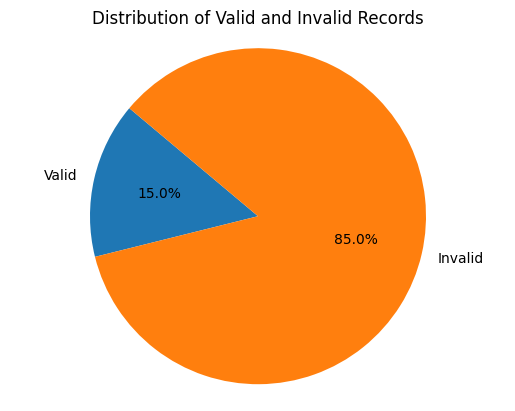

In [ ]:
valid_count = 0
invalid_count = 0

for gen_text_obj in generate_text(config, line_validator=None, num_lines=100):
    line = gen_text_obj.text
    record = dict(zip(["id", "username", "firstName", "lastName", "email", "password", "phone", "userStatus"], line.split(",")))
    mapped_record = gen_mapped_result(record)
    result = {'label': validate_record(mapped_record), 'data': mapped_record}

    if result['label'] == 'valid':
        valid_count += 1
    else:
        invalid_count += 1

# Виведемо кількість "valid" і "invalid" записів
print(f'Valid records: {valid_count}')
print(f'Invalid records: {invalid_count}')

import matplotlib.pyplot as plt

# Дані для графіку
labels = ['Valid', 'Invalid']
counts = [valid_count, invalid_count]

# Створення колодязя (pie chart)
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Забезпечення колодязя круговим

# Виведення графіку
plt.title('Distribution of Valid and Invalid Records')
plt.show()

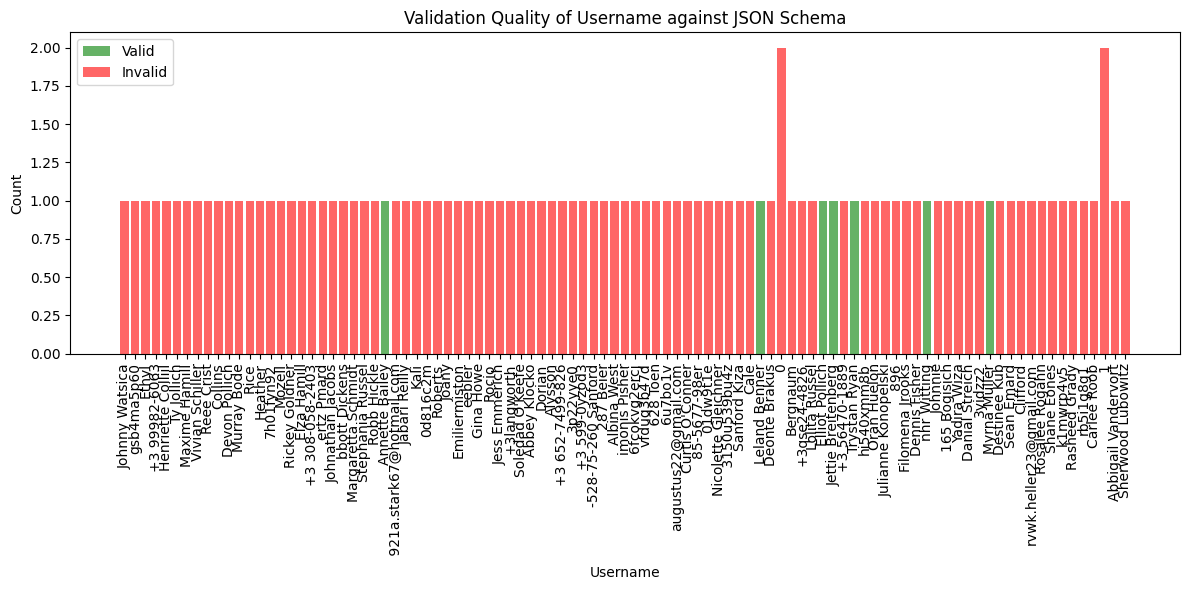

In [ ]:
from collections import Counter
valid_username_counter = Counter()
invalid_username_counter = Counter()

for gen_text_obj in generate_text(config, line_validator=None, num_lines=100):
    line = gen_text_obj.text
    record = dict(zip(["id", "username", "firstName", "lastName", "email", "password", "phone", "userStatus"], line.split(",")))
    mapped_record = gen_mapped_result(record)
    result = {'label': validate_record(mapped_record), 'data': mapped_record}

    if 'username' in mapped_record:
        username = mapped_record['username']
        if result['label'] == 'valid':
            valid_username_counter[username] += 1
        else:
            invalid_username_counter[username] += 1

import matplotlib.pyplot as plt
unique_usernames = list(set(list(valid_username_counter.keys()) + list(invalid_username_counter.keys())))
valid_counts = [valid_username_counter[username] for username in unique_usernames]
invalid_counts = [invalid_username_counter[username] for username in unique_usernames]

# Візуалізація
plt.figure(figsize=(12, 6))  # Змініть розмір графіку за потребою
plt.bar(unique_usernames, valid_counts, label='Valid', color='green', alpha=0.6)
plt.bar(unique_usernames, invalid_counts, label='Invalid', color='red', alpha=0.6)
plt.xlabel('Username')
plt.ylabel('Count')
plt.title('Validation Quality of Username against JSON Schema')

# Поворот міток осі X для кращої читабельності (за потребою)
plt.xticks(rotation=90)

# Додавання легенди
plt.legend()

# Виведення графіку
plt.tight_layout()
plt.show()


<ipython-input-18-c30df476b20c>:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


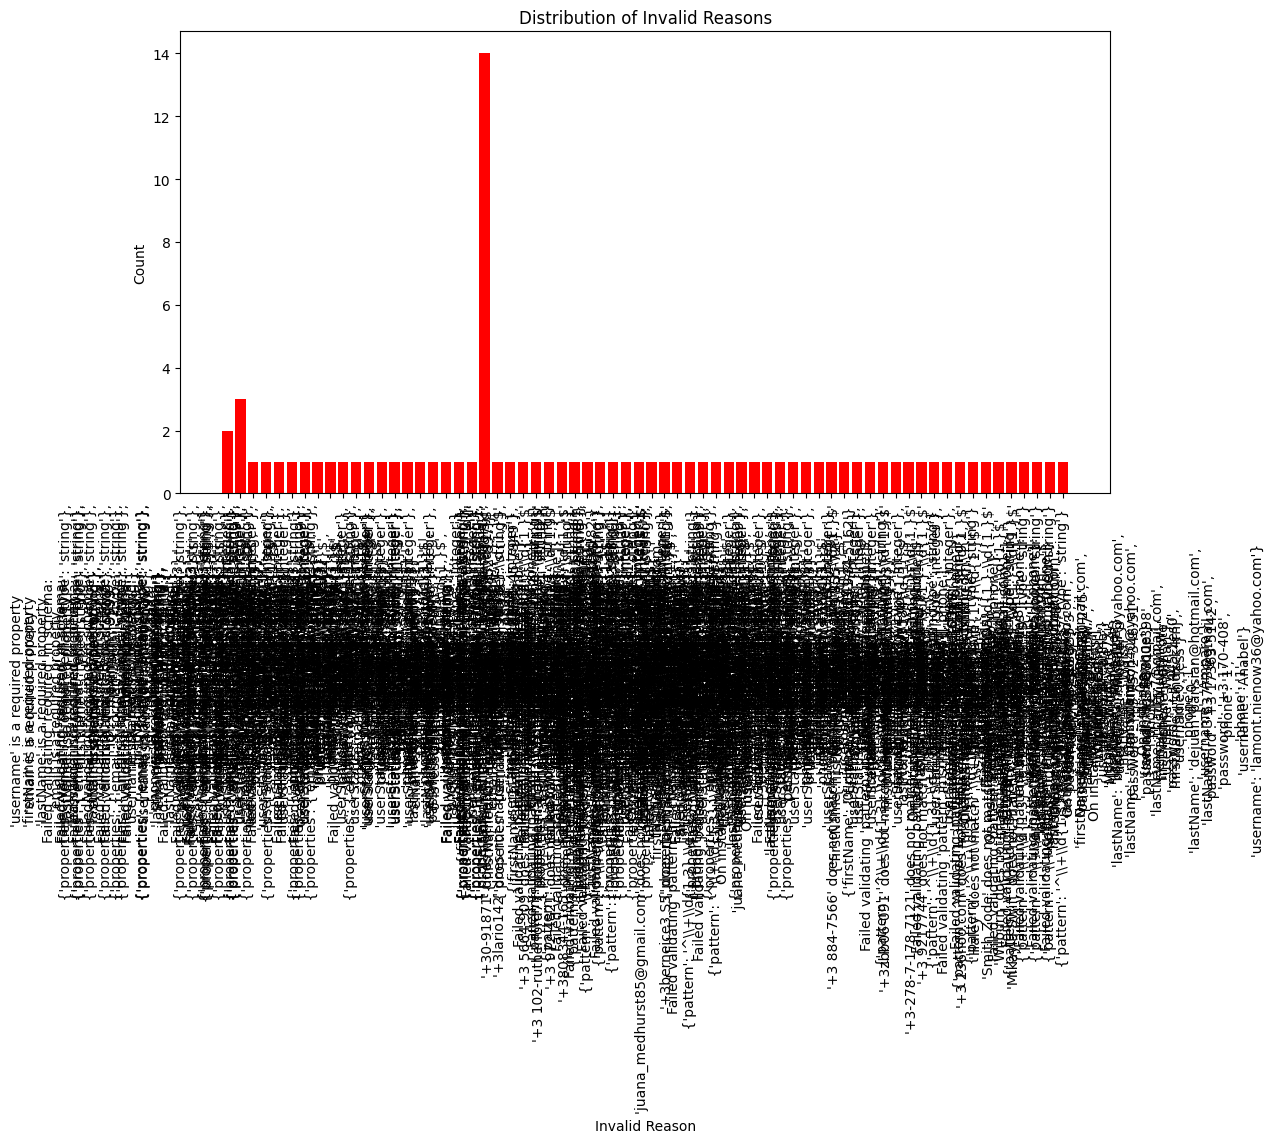

In [ ]:
valid_count = 0
invalid_count = 0
invalid_reasons = {}

for gen_text_obj in generate_text(config, line_validator=None, num_lines=100):
    line = gen_text_obj.text
    record = dict(zip(["id", "username", "firstName", "lastName", "email", "password", "phone", "userStatus"], line.split(",")))
    mapped_record = gen_mapped_result(record)
    result, reason = validate_record(mapped_record)

    if result == 'valid':
        valid_count += 1
    else:
        invalid_count += 1
        if reason not in invalid_reasons:
            invalid_reasons[reason] = 1
        else:
            invalid_reasons[reason] += 1
import matplotlib.pyplot as plt

# Відокремте причини невалідності та кількість відповідних записів
invalid_reason_labels = list(invalid_reasons.keys())
invalid_reason_counts = list(invalid_reasons.values())

# Візуалізація причин невалідності
plt.figure(figsize=(12, 6))  # Змініть розмір графіку за потребою
plt.bar(invalid_reason_labels, invalid_reason_counts, color='red')
plt.xlabel('Invalid Reason')
plt.ylabel('Count')
plt.title('Distribution of Invalid Reasons')

# Поворот міток осі X для кращої читабельності (за потребою)
plt.xticks(rotation=90)

# Виведення графіку
plt.tight_layout()
plt.show()


                                       Invalid Reason  Count
0   'username' is a required property\n\nFailed va...      1
1   'firstName' is a required property\n\nFailed v...      3
2   'firstName' is a required property\n\nFailed v...      1
3   'lastName' is a required property\n\nFailed va...      1
4   'email' is a required property\n\nFailed valid...      1
..                                                ...    ...
66  '+351@yahoo.com' does not match '^\\+\\d{1,3} ...      1
67  '+3yahoo.com' does not match '^\\+\\d{1,3} \\d...      1
68  '+3 536-466@hotmail.com' does not match '^\\+\...      1
69  'david.ortiz62@yahoo.com' does not match '^\\+...      1
70  'username' is a required property\n\nFailed va...      1

[71 rows x 2 columns]


<ipython-input-22-a1855f44127c>:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


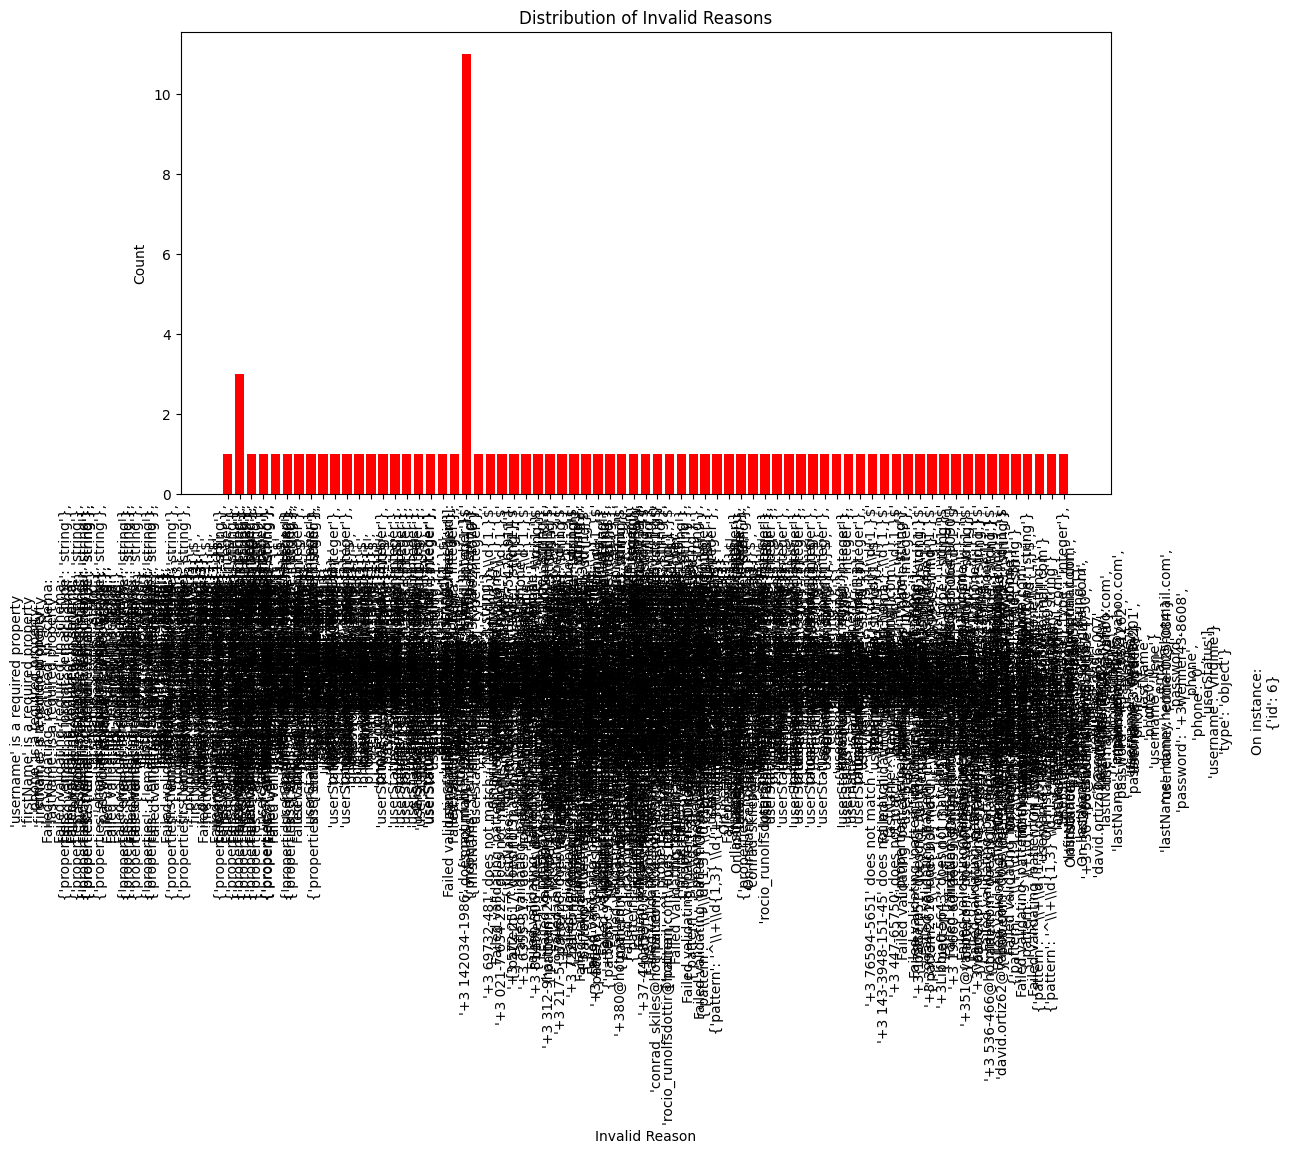

<ipython-input-22-a1855f44127c>:62: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


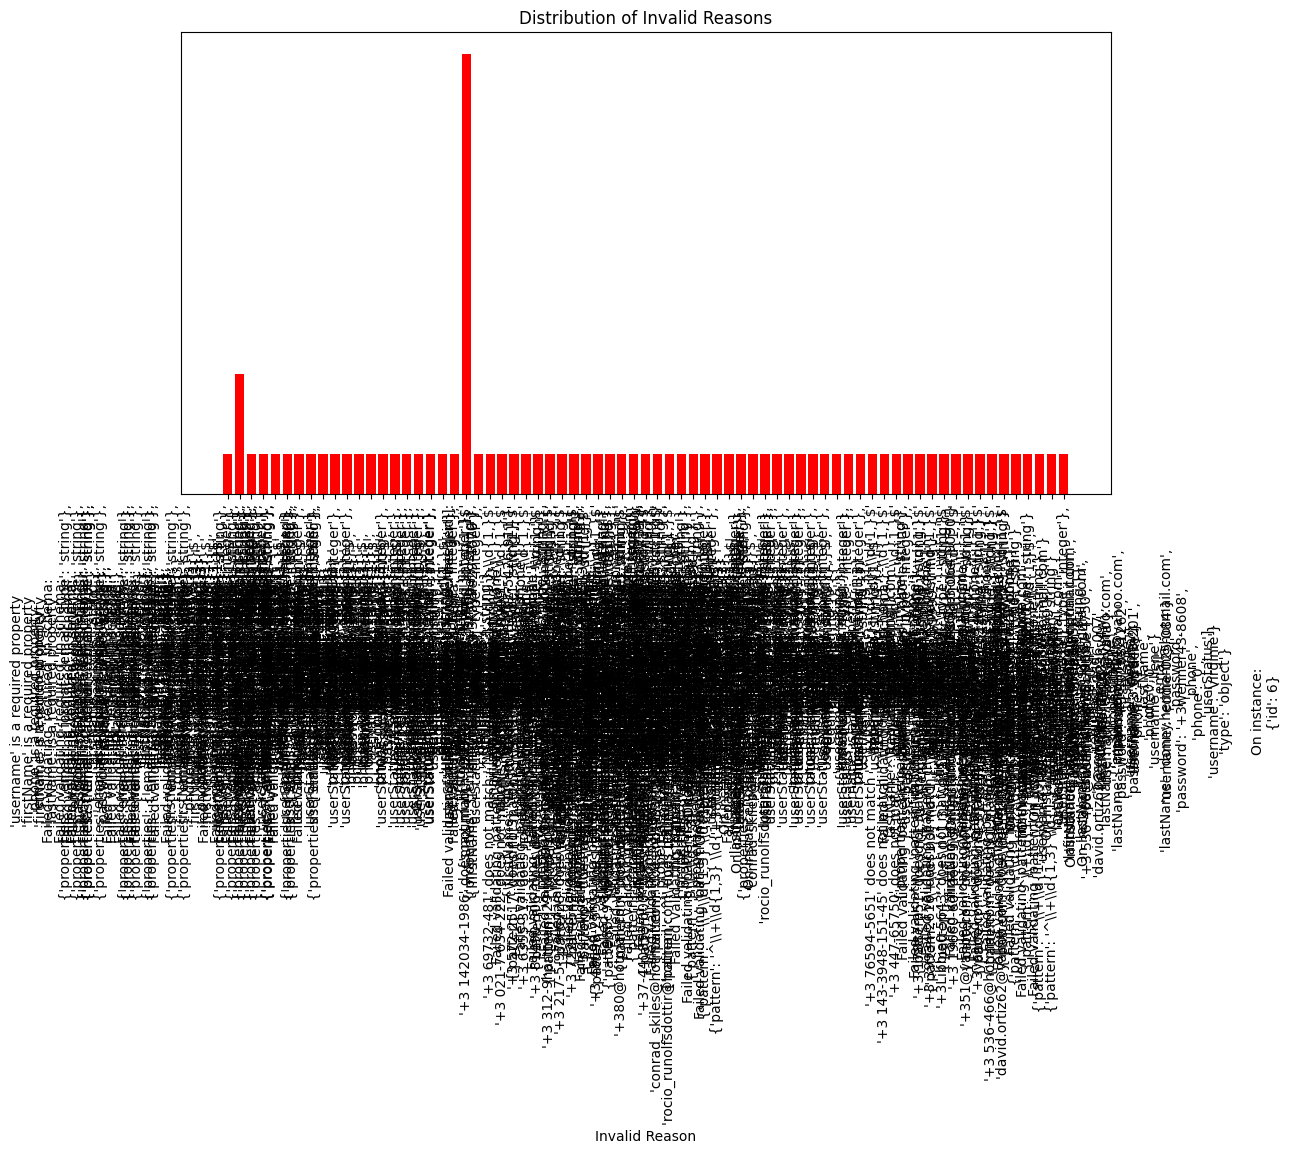

In [ ]:
from collections import defaultdict

def accumulate_invalid_reasons(records):
    invalid_reasons = defaultdict(int)

    for record in records:
        result, reason = validate_record(record)
        if result == 'invalid':
            invalid_reasons[reason] += 1

    return invalid_reasons
records = []

for gen_text_obj in generate_text(config, line_validator=None, num_lines=100):
    line = gen_text_obj.text
    record = dict(zip(["id", "username", "firstName", "lastName", "email", "password", "phone", "userStatus"], line.split(",")))
    mapped_record = gen_mapped_result(record)
    records.append(mapped_record)

invalid_reasons = accumulate_invalid_reasons(records)
import pandas as pd


df = pd.DataFrame({'Invalid Reason': list(invalid_reasons.keys()), 'Count': list(invalid_reasons.values())})


print(df)

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.bar(df['Invalid Reason'], df['Count'], color='red')
plt.xlabel('Invalid Reason')
plt.ylabel('Count')
plt.title('Distribution of Invalid Reasons')


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.bar(df['Invalid Reason'], df['Count'], color='red')
plt.xlabel('Invalid Reason')
plt.ylabel('Count')
plt.title('Distribution of Invalid Reasons')


plt.xticks(rotation=90)
plt.gca().axes.get_yaxis().set_visible(False)

# Виведення графіку
plt.tight_layout()
plt.show()

